In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

import sys, importlib
from scripts.classes import Label, Sample
import scripts.util as util
importlib.reload(sys.modules['scripts.util'])
importlib.reload(sys.modules['scripts.classes'])


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data loading step

In [2]:
TRAIN_DATA = "../data/EuroSatData/train.csv"
TEST_DATA = "../data/EuroSatData/test.csv"
VALIDATION_DATA = "../data/EuroSatData/validation.csv"

# Load data into pandas dataframe from csv files
train_df = pd.read_csv(TRAIN_DATA)
train_df["Filename"] = "../data/EuroSatData/" + train_df["Filename"].astype(str)
test_df = pd.read_csv(TEST_DATA)
test_df["Filename"] = "../data/EuroSatData/" + test_df["Filename"].astype(str)
validation_df = pd.read_csv(VALIDATION_DATA)
validation_df["Filename"] = "../data/EuroSatData/" + validation_df["Filename"].astype(str)

In [3]:
# Load image data into new column called "Image"
train_df["Image"] = train_df["Filename"].apply(util.read_img)
test_df["Image"] = test_df["Filename"].apply(util.read_img)
validation_df["Image"] = validation_df["Filename"].apply(util.read_img)

In [4]:
# Prepare the x and y of each data set
x_train, y_train = util.pd_series_to_tensor(train_df["Image"]), train_df["Label"].values
x_test, y_test = util.pd_series_to_tensor(test_df["Image"]), test_df["Label"].values
x_validation, y_validation = util.pd_series_to_tensor(validation_df["Image"]), validation_df["Label"].values

# Model set up and training

In [5]:
pretrained_vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(64, 64, 3))

In [6]:
pretrained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [7]:
model = tf.keras.Sequential()

In [8]:
# Ignore the last layer, which is the dense layers
for layer in pretrained_vgg16.layers:
  layer.trainable = False
  model.add(layer)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [10]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Activation("softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [12]:
# lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(
#   initial_learning_rate=0.001,
#   decay_steps=10000,
#   decay_rate=0.9
# )

# Overfitting is occuring, try to lower learning rate
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001), # decrease learning rate
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"]
)

EPOCHS = 20
BATCH_SIZE = 16


In [13]:
# NOTE: Possible batch_size configuration
train_history = model.fit(x=x_train, y=y_train, validation_data=(x_validation, y_validation), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/20
1182/1182 - 38s - loss: 0.7424 - accuracy: 0.7524 - val_loss: 0.5744 - val_accuracy: 0.8089 - 38s/epoch - 32ms/step
Epoch 2/20
1182/1182 - 24s - loss: 0.4853 - accuracy: 0.8382 - val_loss: 0.4848 - val_accuracy: 0.8380 - 24s/epoch - 20ms/step
Epoch 3/20
1182/1182 - 20s - loss: 0.4219 - accuracy: 0.8583 - val_loss: 0.4560 - val_accuracy: 0.8480 - 20s/epoch - 17ms/step
Epoch 4/20
1182/1182 - 12s - loss: 0.3834 - accuracy: 0.8701 - val_loss: 0.4238 - val_accuracy: 0.8561 - 12s/epoch - 10ms/step
Epoch 5/20
1182/1182 - 12s - loss: 0.3541 - accuracy: 0.8835 - val_loss: 0.4280 - val_accuracy: 0.8574 - 12s/epoch - 10ms/step
Epoch 6/20
1182/1182 - 12s - loss: 0.3348 - accuracy: 0.8894 - val_loss: 0.4252 - val_accuracy: 0.8565 - 12s/epoch - 10ms/step
Epoch 7/20
1182/1182 - 12s - loss: 0.3186 - accuracy: 0.8939 - val_loss: 0.4161 - val_accuracy: 0.8569 - 12s/epoch - 10ms/step
Epoch 8/20
1182/1182 - 12s - loss: 0.3025 - accuracy: 0.8990 - val_loss: 0.3963 - val_accuracy: 0.8659 - 12s/ep

In [154]:
# Show train losses and accuracy here
train_losses = train_history.history["loss"]
train_accuracy = train_history.history["accuracy"]
val_losses = train_history.history["val_loss"]
val_accuracy = train_history.history["val_accuracy"]

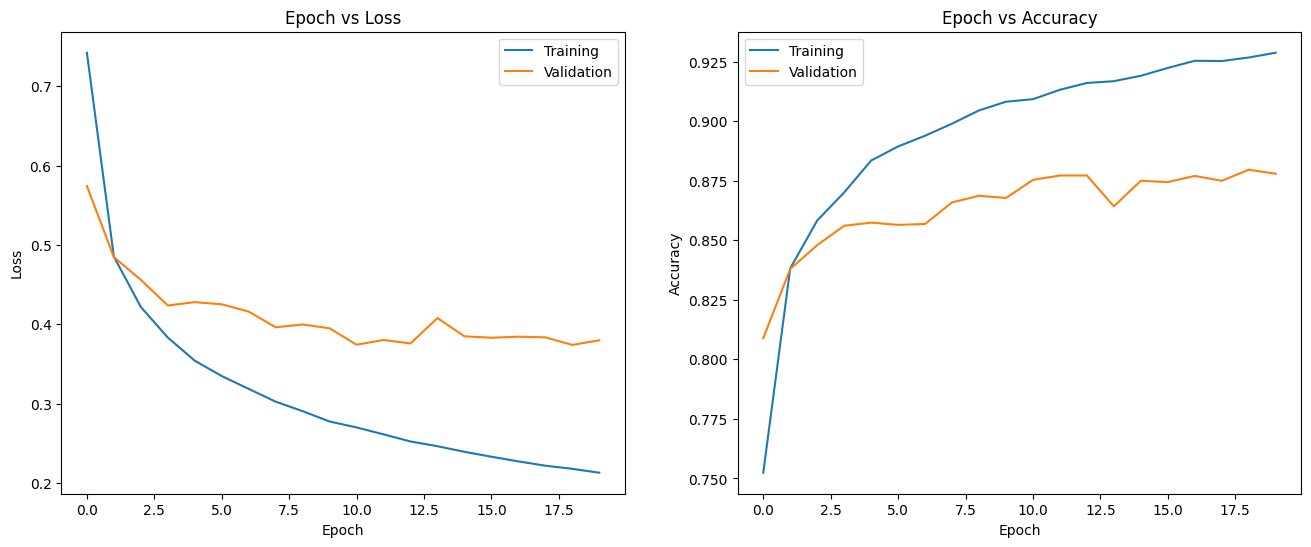

In [158]:
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])

plt.show()


In [15]:
# NOTE: Possible batch_size configuration
prediction = model.predict(x=x_test, verbose=2)
y_prediction = np.argmax(prediction, axis=1)

85/85 - 2s - 2s/epoch - 19ms/step


In [149]:
correct = y_test == y_prediction
test_accuracy = np.sum(correct)/len(y_test)
p_score = precision_score(y_true=y_test, y_pred=y_prediction, average="micro")
r_score = recall_score(y_true=y_test, y_pred=y_prediction, average="micro")
conf_matrix = confusion_matrix(y_test, y_prediction)

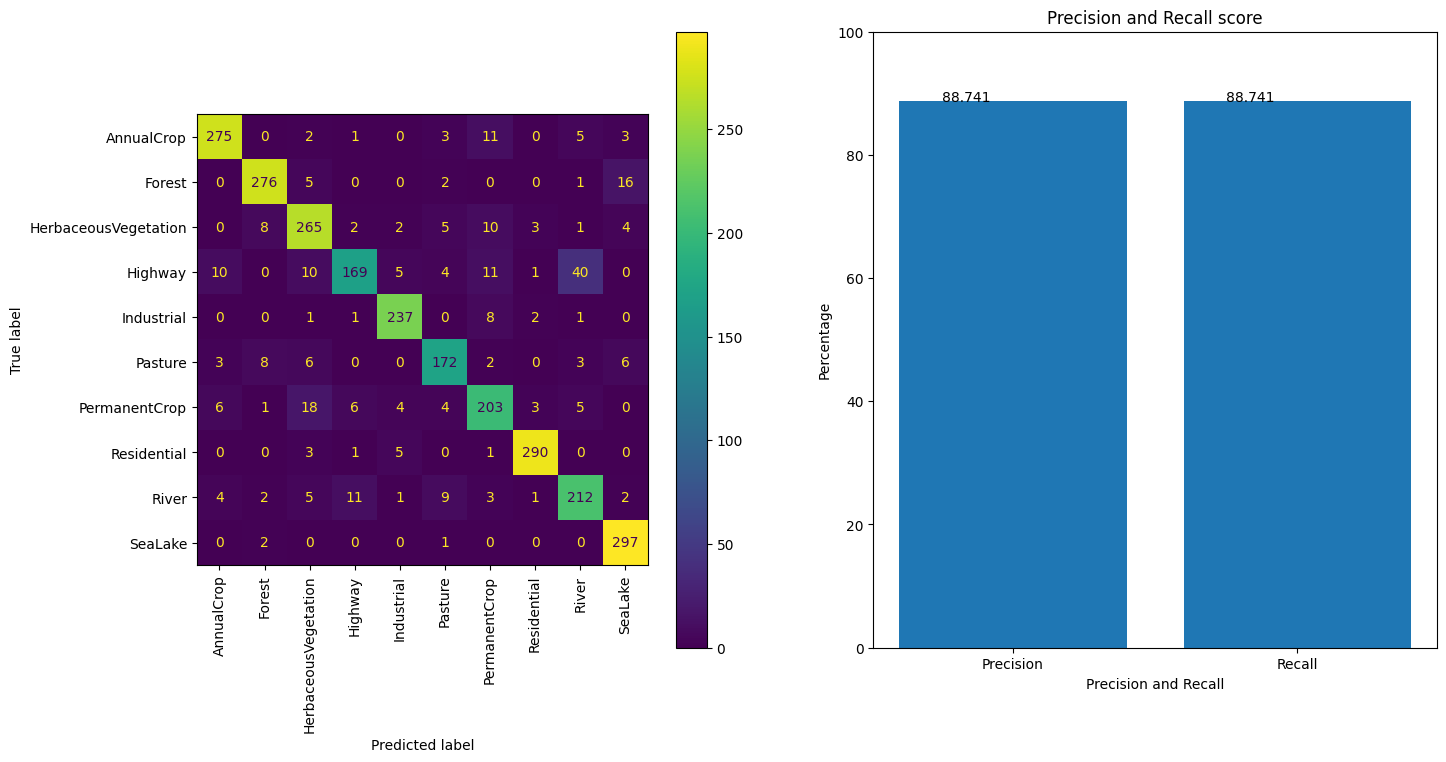

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction, display_labels=Label.label_mappings(), xticks_rotation="vertical", ax=axes[0])
util.plot_recall_precision(axes[1], p_score, r_score)
